<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/ODR(Normal%2C_Cataract%2C_Diabetes%2C_and_Glaucoma)_using_InceptionV3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
! unzip ocular-disease-recognition-odir5k

In [2]:
#Importing libraries
import os
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [3]:
dataset = pd.read_csv('/content/full_df.csv')

In [4]:
dataset.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [8]:
dataset.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

<Axes: xlabel='labels', ylabel='count'>

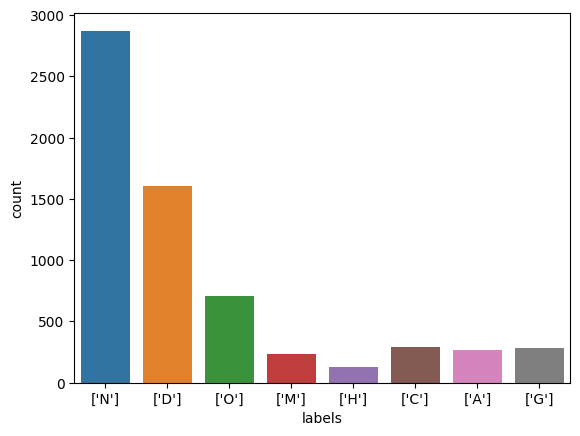

In [6]:
sns.countplot(x = dataset['labels'], data = dataset)

<Axes: xlabel='Patient Sex', ylabel='count'>

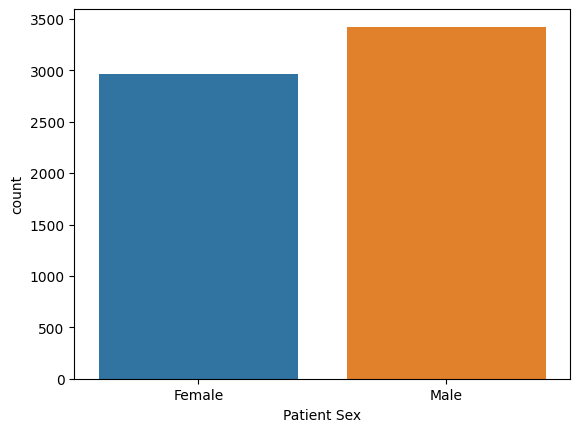

In [9]:
sns.countplot(x = dataset['Patient Sex'], data = dataset)

(array([2968.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3424.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

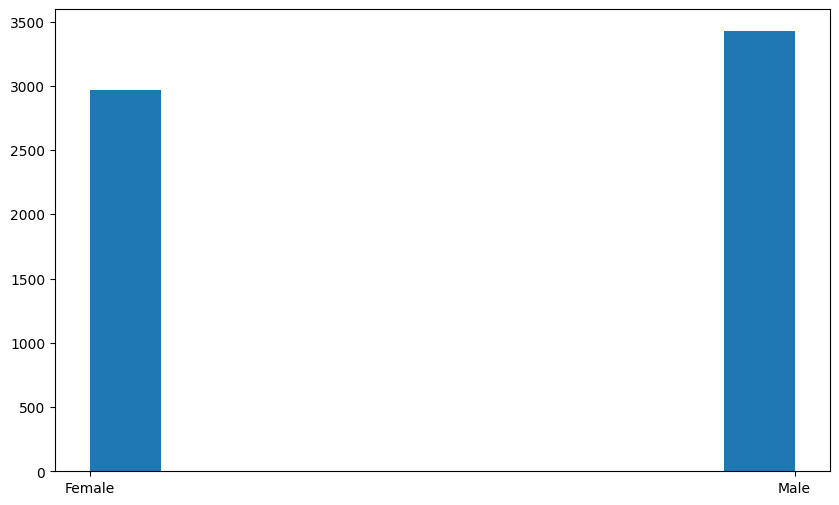

In [10]:
plt.figure(figsize = (10, 6))
plt.hist(dataset['Patient Sex'])

(array([  28.,    8.,   29.,  223.,  589., 1378., 2057., 1511.,  486.,
          83.]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <BarContainer object of 10 artists>)

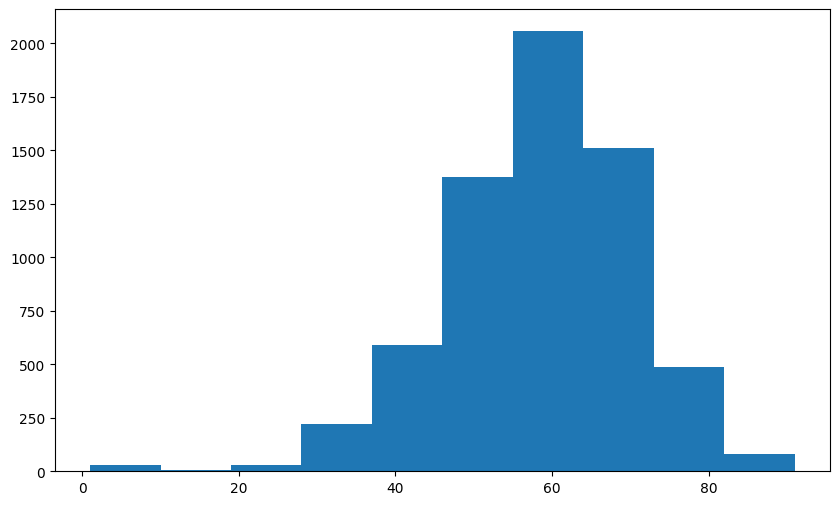

In [11]:
plt.figure(figsize = (10, 6))
plt.hist(dataset['Patient Age'])

**Extracting definitive diagnosis per patient...**

In [12]:
dataset['Left-Diagnostic Keywords'].unique()

array(['cataract', 'normal fundus',
       'laser spot，moderate non proliferative retinopathy',
       'macular epiretinal membrane',
       'moderate non proliferative retinopathy', 'drusen',
       'epiretinal membrane',
       'moderate non proliferative retinopathy，hypertensive retinopathy',
       'pathological myopia', 'mild nonproliferative retinopathy',
       'hypertensive retinopathy',
       'macular epiretinal membrane，mild nonproliferative retinopathy',
       'macular hole', 'wet age-related macular degeneration',
       'moderate non proliferative retinopathy，laser spot',
       'moderate non proliferative retinopathy，myelinated nerve fibers',
       'dry age-related macular degeneration',
       'epiretinal membrane，myelinated nerve fibers',
       'diabetic retinopathy', 'epiretinal membrane，lens dust', 'atrophy',
       'laser spot，white vessel，moderate non proliferative retinopathy',
       'chorioretinal atrophy',
       'moderate non proliferative retinopathy，catar

**In out dataset, we used 4 classes:**
- - Normal
- - Glaucoma
- - Cataract
- - Diabetic Retinopathy
     - mild nonproliferative retinopathy
     - proliferative retinopathy
     - diabetic retinopathy
     - moderate non proliferative retinopathy

In [14]:
def has_cataract(text):
    if "cataract" in text:
        return 2
    else:
        return 0

dataset['left_cataract'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_cataract(x))
dataset['right_cataract'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_cataract(x))

left_cataract = dataset.loc[(dataset.C == 1) & (dataset['left_cataract'] == 2)]['Left-Fundus'].values
right_cataract = dataset.loc[(dataset.C == 1) & (dataset['right_cataract'] == 2)]['Right-Fundus'].values
cataract = np.concatenate((left_cataract, right_cataract), axis=0)

In [15]:
def has_normal_fundus(text):
    if "normal fundus" in text:
        return 1
    else:
        return 0

dataset['left_normal'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))
dataset['right_normal'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))

left_normal = dataset.loc[(dataset.N == 1) & (dataset['left_normal'] == 1)]["Left-Fundus"].values
right_normal = dataset.loc[(dataset.N == 1) & (dataset["right_normal"] == 1)]["Right-Fundus"].values
normal = np.concatenate((left_normal, right_normal), axis=0)

In [16]:
def has_retinopathy(text):
  if ('mild nonproliferative retinopathy') or ('proliferative retinopathy') or ('diabetic retinopathy') or ('moderate non proliferative retinopathy') in text:
    return 3
  else:
    return 0

dataset['left_diabetes'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))
dataset['right_diabetes'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))

left_diabetes = dataset.loc[(dataset.D == 1) & (dataset['left_diabetes'] == 3)]['Left-Fundus'].values
right_diabetes = dataset.loc[(dataset.D == 1) & (dataset['right_diabetes'] == 3)]['Right-Fundus'].values
diabetes = np.concatenate((left_diabetes, right_diabetes), axis=0)

In [17]:
def has_glaucoma(text):
  if 'glaucoma' in text:
    return 4
  else:
    return 0

dataset['left_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))
dataset['right_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))

left_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['left_glaucoma'] == 4)]['Left-Fundus'].values
right_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['right_glaucoma'] == 4)]['Right-Fundus'].values
glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis=0)

In [19]:
print("Cataract : ", len(cataract))
print("Normal : ", len(normal))
print("Glaucoma : ", len(glaucoma))
print("Diabetes : ", len(diabetes))

Cataract :  594
Normal :  4201
Glaucoma :  664
Diabetes :  4246
